# Transcription Factor Project - QC Testing
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:** What do TF KO effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

**Notebook Description:** Testing lack of TF KO overlap when using different random seeds

***

# Import statements and global random seed

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import scipy as sp
#import re
#import requests
import gc
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import delayed, parallel_backend, Parallel
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

In [2]:
# Set global random seed as safety measure for reproducibility
np.random.seed(92093)

# Investigating how different random seeds yield different sets of TF KOs

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

def filter_tf_ko_and_ntc(adata):
    """
    Filter for TF KO and NTC cells.
    """
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def get_tf_kos_3_batches(tf_set, adata1, adata2, adata3):
    """
    Return set of unique TF KOs present in union of 3 datasets.
    """
    tf_kos = set()
    for adata in (adata1, adata2, adata3):
        adata_kos = set(adata.obs["gene_target"].unique().tolist())
        adata_tf_kos = tf_set & adata_kos # Gene targets that are in TF set
        tf_kos.update(set(adata_tf_kos))
    return tf_kos

In [ ]:
def plot_venn(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 16
    n_items1, n_items2 = len(set1), len(set2)
    n_shared = len([g for g in set2 if g in set1])
    left = n_items1 - n_shared
    right = n_items2 - n_shared
    venn2(subsets = (left, right, n_shared), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

In [4]:
def plot_venn3(set1, set2, set3, label1, label2, label3, title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 14
    venn3(subsets=[set1, set2, set3], 
          set_labels=(label1, label2, label3), 
          set_colors=(color1, color2, color3), alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

## Steps E and F

### Step E output

In [25]:
# Datasets processed with RNG-modified code for Sept 12
stepE_alpha_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad", backed='r')
stepE_beta_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad", backed='r')
stepE_gamma_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad", backed='r')

In [26]:
stepE_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepE_alpha_mod_sept12, stepE_beta_mod_sept12, stepE_gamma_mod_sept12)

In [27]:
# Datasets processed with original code and random seed
stepE_alpha_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_1randseed.h5ad", backed="r")
stepE_beta_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_1randseed.h5ad", backed="r")
stepE_gamma_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_1randseed.h5ad", backed="r")

In [28]:
stepE_tf_kos_seed = get_tf_kos_3_batches(tfs, stepE_alpha_seed, stepE_beta_seed, stepE_gamma_seed)

In [29]:
# Datasets processed with RNG-modified code for Sept 26th
stepE_alpha_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad", backed='r')
stepE_beta_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad", backed='r')
stepE_gamma_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad", backed='r')

In [30]:
stepE_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepE_alpha_mod_sept26, 
                                         stepE_beta_mod_sept26, stepE_gamma_mod_sept26)

In [31]:
print("After Step E:")
print(f"tf_kos_mod_sept12 = {len(stepE_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(stepE_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(stepE_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(stepE_tf_kos_mod_sept12 & stepE_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(stepE_tf_kos_mod_sept26 & stepE_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(stepE_tf_kos_mod_sept12 & stepE_tf_kos_mod_sept26)} TF KOs")

After Step E:
tf_kos_mod_sept12 = 1388 TF KOs, tf_kos_seed = 1390 TF KOs, tf_kos_mod_sept26 = 1387 TF KOs
Shared between 9/12 and global seed = 1384 TF KOs
Shared between global seed and 9/26 = 1382 TF KOs
Shared between 9/12 and 9/26 = 1386 TF KOs


### Step F energy distance testing output

In [11]:
# Datasets processed with RNG-modified code for Sept 12th
stepF_alpha_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad", backed="r")
stepF_beta_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad", backed="r")
stepF_gamma_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad", backed="r")

In [12]:
energy_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_mod_sept12, 
    stepF_beta_energy_mod_sept12, stepF_gamma_energy_mod_sept12)

In [13]:
# Datasets processed with original code and random seed
stepF_alpha_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_1randseed.h5ad", backed="r")
stepF_beta_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_1randseed.h5ad", backed="r")
stepF_gamma_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_1randseed.h5ad", backed="r")

In [14]:
energy_tf_kos_seed = get_tf_kos_3_batches(tfs, stepF_alpha_energy_seed, stepF_beta_energy_seed, stepF_gamma_energy_seed)

In [15]:
# Datasets processed with RNG-modified code for Sept 26th
stepF_alpha_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_beta_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_gamma_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad", backed="r")

In [16]:
energy_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_mod_sept26, 
    stepF_beta_energy_mod_sept26, stepF_gamma_energy_mod_sept26)

In [19]:
print("After Step F filtering based on energy distance testing:")
print(f"tf_kos_mod_sept12 = {len(energy_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(energy_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(energy_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(energy_tf_kos_mod_sept12 & energy_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(energy_tf_kos_mod_sept26 & energy_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(energy_tf_kos_mod_sept12 & energy_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between all 3: {len(energy_tf_kos_mod_sept12 & energy_tf_kos_mod_sept26 & energy_tf_kos_seed)} TF KOs")

After Step F filtering based on energy distance testing:
tf_kos_mod_sept12 = 989 TF KOs, tf_kos_seed = 907 TF KOs, tf_kos_mod_sept26 = 905 TF KOs
Shared between 9/12 and global seed = 698 TF KOs
Shared between global seed and 9/26 = 641 TF KOs
Shared between 9/12 and 9/26 = 737 TF KOs
Shared between all 3: 542 TF KOs


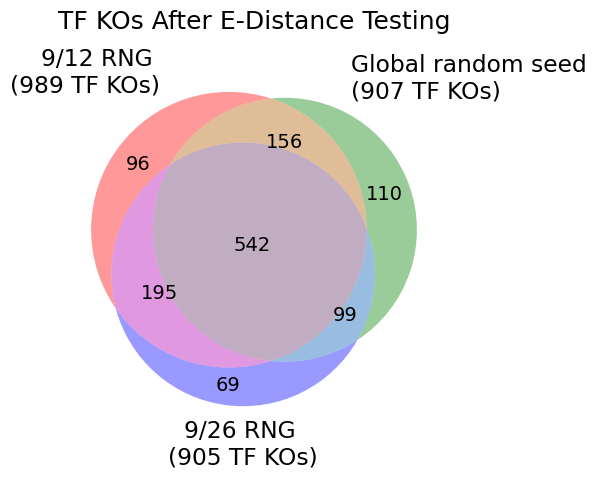

In [51]:
plot_venn3(energy_tf_kos_mod_sept12, energy_tf_kos_seed, energy_tf_kos_mod_sept26, 
           "9/12 RNG \n(989 TF KOs)", "Global random seed \n(907 TF KOs)", "9/26 RNG \n(905 TF KOs)", 
           title="TF KOs After E-Distance Testing\n")

### Step F SVM output

In [3]:
stepF_alpha_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad", backed="r")
stepF_beta_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad", backed="r")
stepF_gamma_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad", backed="r")

In [4]:
svm_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_mod_sept12, stepF_beta_svm_mod_sept12, stepF_gamma_svm_mod_sept12)

In [5]:
stepF_alpha_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_1randseed.h5ad", backed="r")
stepF_beta_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_1randseed.h5ad", backed="r")
stepF_gamma_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_1randseed.h5ad", backed="r")

In [6]:
svm_tf_kos_seed = get_tf_kos_3_batches(tfs, stepF_alpha_svm_seed, stepF_beta_svm_seed, stepF_gamma_svm_seed)

In [7]:
# Datasets processed with RNG-modified code for Sept 26th
stepF_alpha_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final.h5ad", backed="r")
stepF_beta_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final.h5ad", backed="r")
stepF_gamma_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final.h5ad", backed="r")

In [8]:
svm_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_mod_sept26, 
    stepF_beta_svm_mod_sept26, stepF_gamma_svm_mod_sept26)

In [20]:
print("After Step F filtering based on SVM:")
print(f"tf_kos_mod_sept12 = {len(svm_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(svm_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(svm_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(svm_tf_kos_mod_sept12 & svm_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(svm_tf_kos_mod_sept26 & svm_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(svm_tf_kos_mod_sept12 & svm_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between all 3: {len(svm_tf_kos_mod_sept12 & svm_tf_kos_mod_sept26 & svm_tf_kos_seed)} TF KOs")

After Step F filtering based on SVM:
tf_kos_mod_sept12 = 660 TF KOs, tf_kos_seed = 629 TF KOs, tf_kos_mod_sept26 = 612 TF KOs
Shared between 9/12 and global seed = 381 TF KOs
Shared between global seed and 9/26 = 357 TF KOs
Shared between 9/12 and 9/26 = 412 TF KOs
Shared between all 3: 260 TF KOs


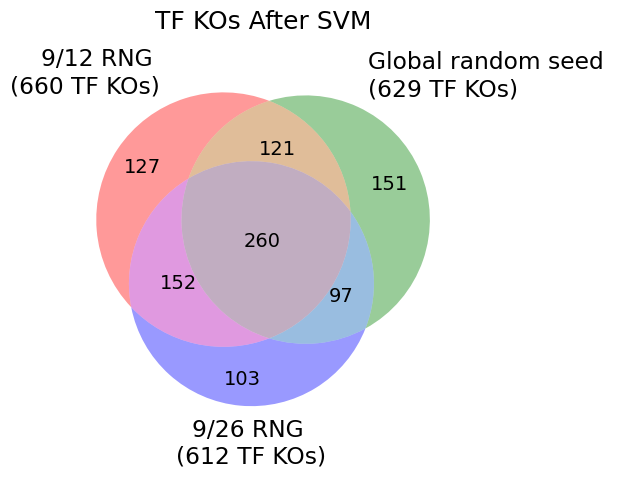

In [52]:
plot_venn3(svm_tf_kos_mod_sept12, svm_tf_kos_seed, svm_tf_kos_mod_sept26, 
           "9/12 RNG \n(660 TF KOs)", "Global random seed \n(629 TF KOs)", "9/26 RNG \n(612 TF KOs)", 
           title="TF KOs After SVM\n")

## Step F testing

### Step F with modified RNG functions (seed = 1337)

PCA seeds = 0

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets.

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7406 [00:00<?, ?it/s]

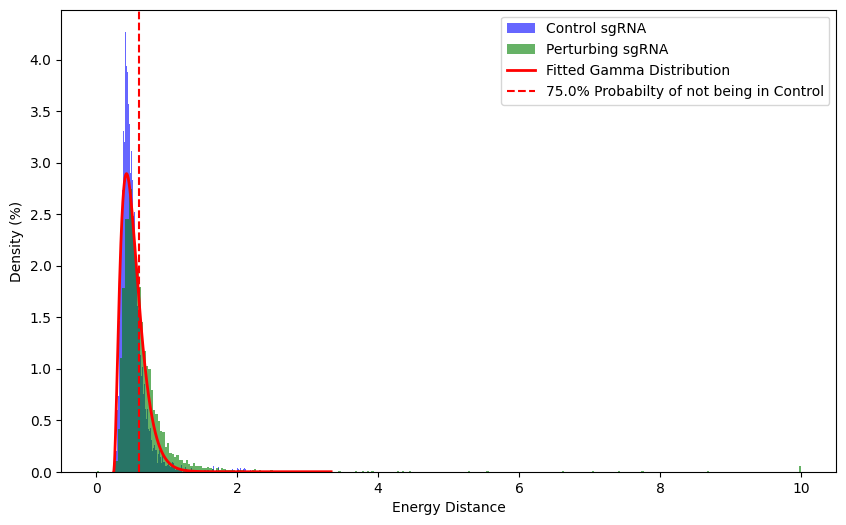

2939/7406 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
del alpha_filtered
gc.collect()

37401

BETA:

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8766 [00:00<?, ?it/s]

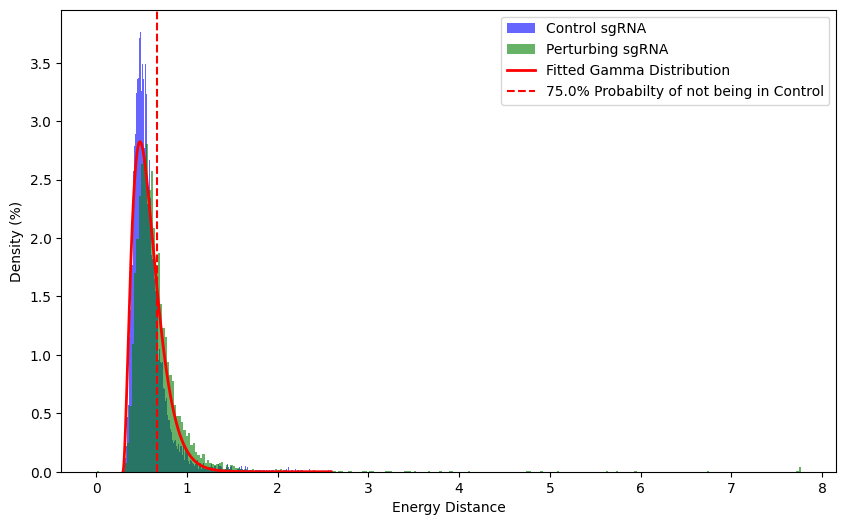

3194/8766 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng)

In [ ]:
beta_filtered = beta_filtered.copy()

In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

In [ ]:
del beta_filtered
gc.collect()

37610

GAMMA:

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8262 [00:00<?, ?it/s]

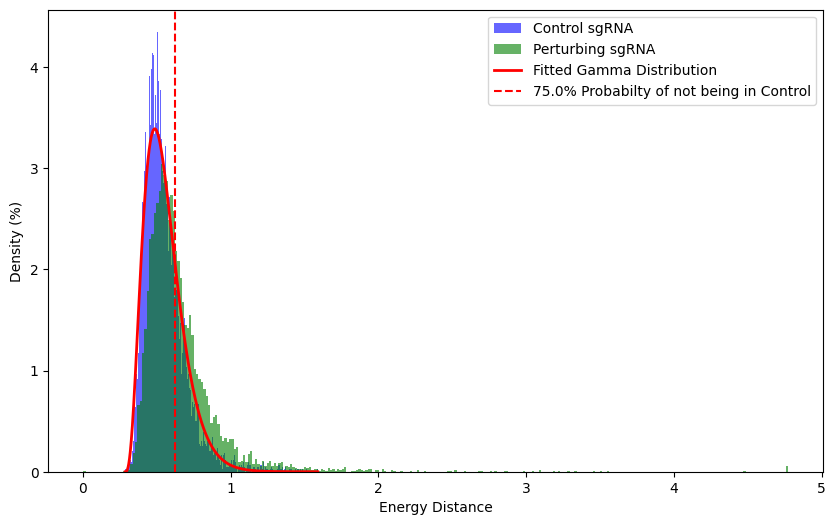

3541/8262 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng)

In [ ]:
gamma_filtered = gamma_filtered.copy()

In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

Restart kernel

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

In [ ]:
step_f_rm_rand_seed = 0 # PCA random_state

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
adata_alpha

AnnData object with n_obs × n_vars = 235798 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:17)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


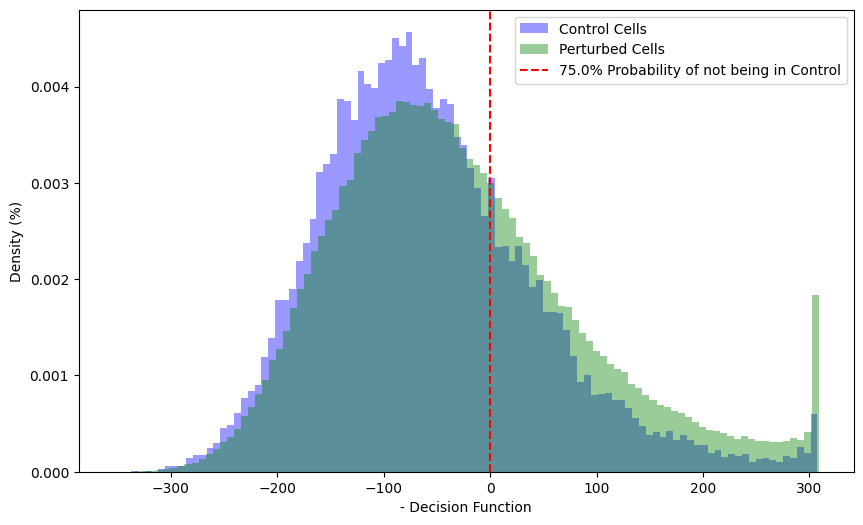

75190/222500 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1333 ['NTC', 'KAT2A', 'ARHGAP35', 'LRPPRC', 'CABIN1', 'ZNF787', 'ZFP82', 'ESRRG', 'DNMT1', 'NPM2', 'EHMT1', 'TENT4B', 'VDR', 'PCGF1', 'FOXH1', 'TSFM', 'INTS12', 'PNPT1', 'ZNF20', 'EZH2', 'ZSCAN18', 'ZNF396', 'ARNT2', 'UHRF1', 'PGR', 'TFAM', 'METTL24', 'CDYL2', 'KMT5C', 'ZNF521', 'ZNF875', 'ELOA', 'SMARCC1', 'DHX36', 'EHMT2', 'RNASEH1', 'DDX6', 'PAXIP1', 'DFFB', 'ZFP37', 'GNMT', 'DBX2', 'METTL7B', 'ANKZF1', 'ZNF362', 'MTA1', 'SMARCE1', 'SHOX2', 'HNF1A', 'POU5F1', 'LEMD3', 'KDM4B', 'H2BK1', 'ZNF426', 'ACTB', 'SUZ12', 'SOX4', 'MED19', 'SCX', 'POLRMT', 'RNF2', 'JMJD8', 'PPARGC1B', 'NABP2', 'POGZ', 'ZNF276', 'ACSF2', 'TRIM37', 'SCAI', 'KMT2D', 'UBR3', 'NEUROD4', 'SETDB1', 'DOT1L', 'FOXJ1', 'NCOA7', 'RCOR2', 'CDK13', 'SMAD4', 'CHAMP1', 'NANOG', 'H4C2', 'FOXD4', 'RLIM', 'EMSY', 'ZFP92', 'SETD7', 'ZNF551', 'BARX1', 'ZNF44', 'BARHL1', 'ZNF687', 'OVOL1', 'ZNF280B', 'ASF1A', 'MLLT1', 'SIN3B', 'EID1', 'ZNF469', 'SLC27A1', 'ZNF358', 'CCDC85B', 'HEXIM1', 'HHEX', 'GATAD1', 'IRF9', 'PARP16', 'SCRT2', 

In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 749 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 75341 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final.h5ad")

In [ ]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16720

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


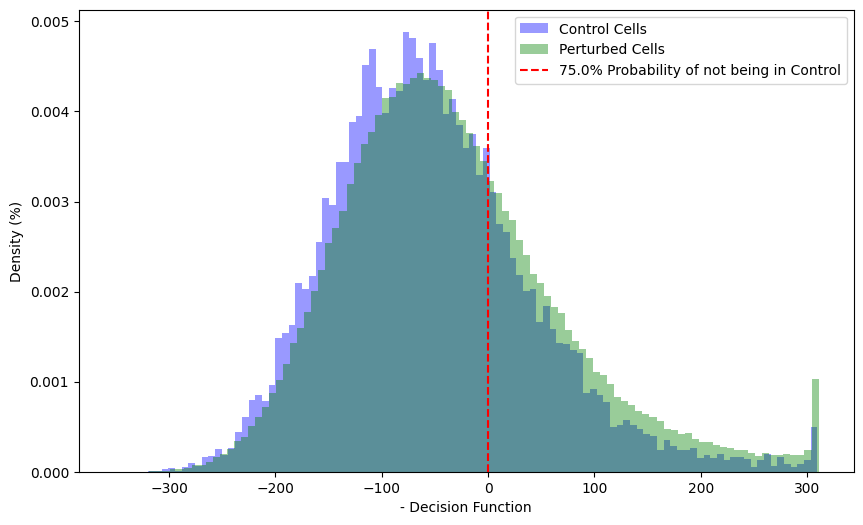

76834/245988 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1353 ['NTC', 'CASP6', 'CCDC6', 'SLC39A13', 'BBC3', 'HCCS', 'VPS33A', 'VHL', 'UBE2M', 'RGS19', 'SLC30A1', 'MZT2A', 'UBFD1', 'PLIN3', 'ENHO', 'FBXO45', 'B3GAT3', 'LATS2', 'DTD2', 'SEMA6C', 'NAE1', 'PGM1', 'RNPEPL1', 'NDUFAF4', 'CRYGD', 'PDPR', 'ANKRD39', 'ANKRD9', 'FASTKD5', 'DESI2', 'LAMTOR1', 'PLOD3', 'ARFGAP1', 'TEFM', 'ORMDL1', 'MTHFR', 'CDKN2AIPNL', 'CYCS', 'TMEM98', 'IGF2R', 'IFFO1', 'ARSA', 'S100A11', 'TESK1', 'WDR91', 'TBRG4', 'JOSD1', 'RASL10B', 'AK4', 'INPP5J', 'PRSS53', 'STEAP3', 'AMOTL2', 'CHP2', 'LAMTOR5', 'IKBIP', 'MRPL36', 'ARL4D', 'HRH3', 'FXYD6', 'VPS39', 'MRPL11', 'POGLUT3', 'OSBPL2', 'FUOM', 'UNC50', 'ETNK2', 'SOCS1', 'TAGLN2', 'KHDC4', 'MTRES1', 'TNKS2', 'HNRNPM', 'DSP', 'PLA2G12A', 'HMBS', 'ZFAND2B', 'CSTB', 'UFSP1', 'CDO1', 'MRPS27', 'CTSL', 'MRPL10', 'FBXO2', 'TOE1', 'CKAP2', 'IFFO2', 'RUSF1', 'APMAP', 'CRELD1', 'WFS1', 'COX6B1', 'MRPL24', 'PCDH1', 'FNDC4', 'SRRD', 'LRFN3', 'MRPL58', 'GPR62', 'ADRA2C', 'FCHSD1', 'RAB5A', 'MYADM', 'GOLGA5', 'ELAVL1', 'CNOT11', 'MYL9

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 945 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 73543 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final.h5ad")

In [ ]:
del adata_beta, adata_beta_filtered
gc.collect()

17401

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


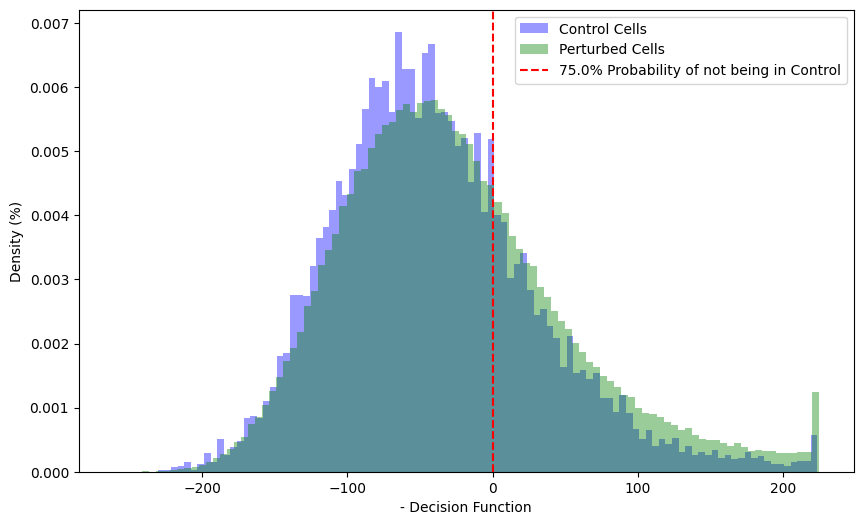

64218/207387 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1070 ['NTC', 'FLYWCH2', 'SUPT20H', 'NF2', 'ABCD1', 'HS2ST1', 'FAM193A', 'C15orf61', 'DDT', 'BAK1', 'FLCN', 'RALGAPB', 'IL17RD', 'STOML1', 'CDC42EP1', 'VSIG10', 'TIMM50', 'FGF21', 'CTAGE15', 'CHRD', 'DNAL4', 'NPC1', 'FECH', 'ADCY9', 'EIF4ENIF1', 'CDON', 'TGFBR2', 'EFNB3', 'MPC2', 'SCAF8', 'TMEM74B', 'SYT7', 'USP45', 'DAP', 'AKAP9', 'BAD', 'SLC35F5', 'PLXND1', 'ARL3', 'RPL39L', 'UNC5B', 'DTX2', 'CAB39', 'ERO1A', 'DECR2', 'SPAG9', 'HIBADH', 'CAMK2N2', 'PAQR3', 'TSEN54', 'CISD3', 'TBC1D7', 'FAM98A', 'KTN1', 'GDAP1', 'POMT2', 'NCAN', 'AGTPBP1', 'UQCC1', 'C1orf21', 'PAPSS1', 'WASHC2C', 'AP5S1', 'TIE1', 'PEX13', 'NPIPA3', 'BCL2L12', 'OSBPL7', 'CYP2R1', 'MBOAT1', 'WNK2', 'SH3D19', 'FLT1', 'GOLGA6A', 'HPRT1', 'DSE', 'C18orf32', 'BEND4', 'RNF11', 'CNST', 'MCOLN1', 'HEATR6', 'RETREG2', 'KLHL24', 'RET', 'KLHL4', 'NRBP1', 'FRAS1', 'SLC25A51', 'FAM221A', 'TAC1', 'MAP4K5', 'BLTP1', 'CYP2D6', 'MTPAP', 'APAF1', 'CYBRD1', 'NADK2', 'DNAJC16', 'SLC29A2', 'EDNRB', 'GARIN5A', 'GCSAM', 'CCDC87', 'DFFA', 'USP

In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1408 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 52126 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final.h5ad")

Restart kernel

### Step F with modified RNG functions (E-dist seed = 42, SVM seed = 0)

Using "_final" dataset. Use random seed of 42 instead of 1337 as previously used. PCA seeds = 0.

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets.

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 42
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7406 [00:00<?, ?it/s]

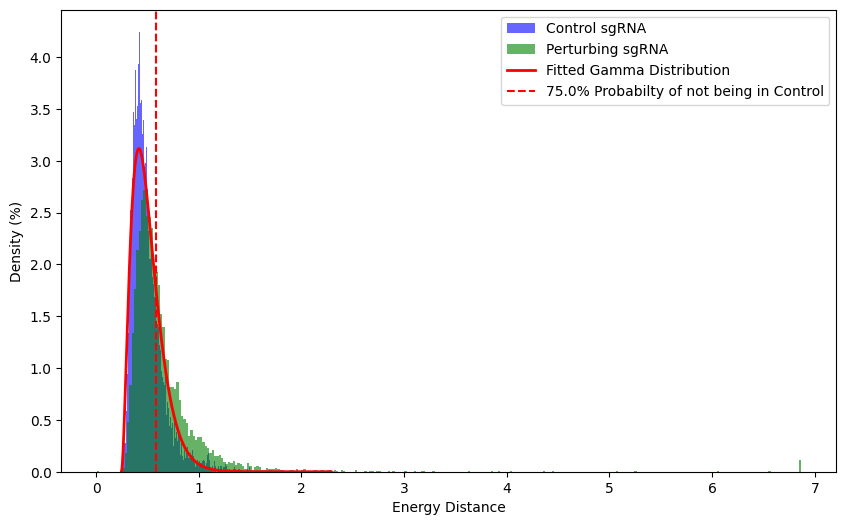

3260/7406 Perturbing sgRNA cross threshold of 0.75


In [4]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng)

In [5]:
alpha_filtered = alpha_filtered.copy()

In [6]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [7]:
del alpha_filtered
gc.collect()

37664

BETA:

In [8]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:07)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8766 [00:00<?, ?it/s]

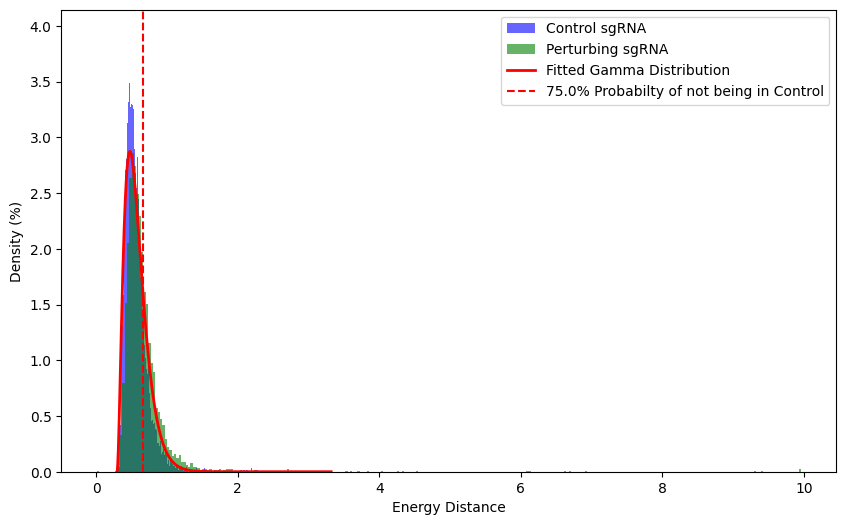

3154/8766 Perturbing sgRNA cross threshold of 0.75


In [9]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng)

In [10]:
beta_filtered = beta_filtered.copy()

In [11]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

In [12]:
del beta_filtered
gc.collect()

37410

GAMMA:

In [13]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8262 [00:00<?, ?it/s]

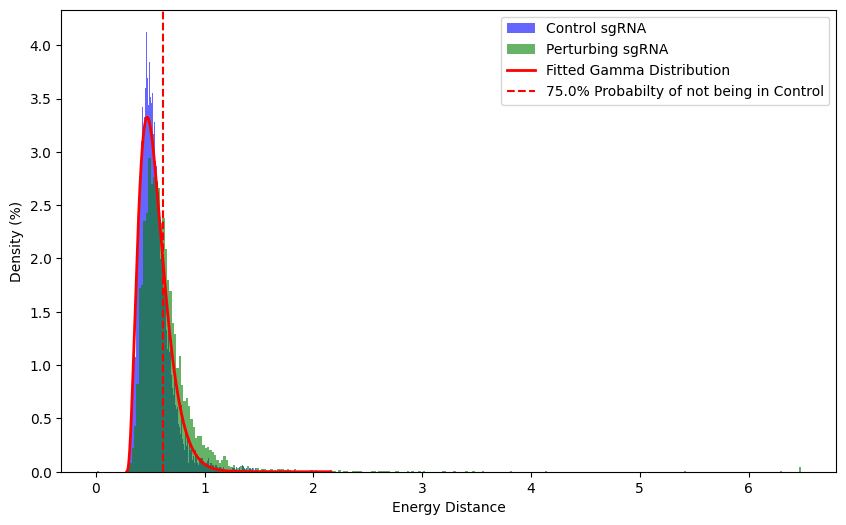

3466/8262 Perturbing sgRNA cross threshold of 0.75


In [14]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng)

In [15]:
gamma_filtered = gamma_filtered.copy()

In [16]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

Restart kernel

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

Use PCA random_state = 0

In [2]:
step_f_rm_rand_seed = 0 # PCA random_state

ALPHA:

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [4]:
adata_alpha

AnnData object with n_obs × n_vars = 262550 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


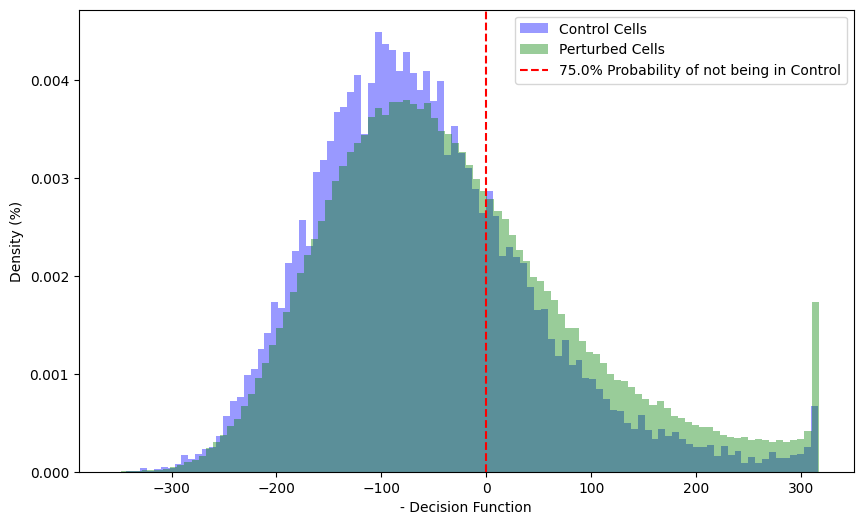

82407/249252 Perturbed Cells cross threshold of 0.75


In [5]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [6]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1480 ['NTC', 'HNF4A', 'KAT2A', 'VDR', 'LRPPRC', 'CABIN1', 'ZNF787', 'DNMT1', 'CHAMP1', 'PCGF1', 'EHMT1', 'TADA2B', 'POGZ', 'EMSY', 'ZNF273', 'NSD2', 'PNPT1', 'UHRF1', 'TBXT', 'INTS12', 'TAF6L', 'ZFP28', 'ZBTB22', 'FOXH1', 'ALKBH1', 'ZNF875', 'DDX6', 'ZNF396', 'EOMES', 'EHMT2', 'ZNF697', 'SIN3B', 'BMAL2', 'ELOC', 'TFAM', 'HIC1', 'ASS1', 'SOX4', 'ZNF426', 'ZNF419', 'ZNF829', 'ZFP57', 'ESRRA', 'NR0B1', 'SMARCC1', 'POU5F1', 'USP17L2', 'ACTB', 'PDP1', 'LEMD3', 'DOT1L', 'ZNF683', 'POLRMT', 'PRMT5', 'SNAI3', 'SMARCE1', 'ZNF287', 'ADNP2', 'OLIG1', 'BRD1', 'PKNOX2', 'BHLHE40', 'ZNF420', 'ZNF132', 'KMT2E', 'ZNF596', 'MTA2', 'ZNF556', 'HOXB3', 'NANOG', 'PARP16', 'SETDB1', 'CRTC2', 'SWAP70', 'H3-7', 'ZFP41', 'SLC22A1', 'ARHGAP35', 'ASF1A', 'FOXJ1', 'SUZ12', 'RCOR2', 'ZNF713', 'ZNF700', 'CDK13', 'RLIM', 'SSBP1', 'TCF21', 'MEIS3', 'RNASE6', 'SP4', 'ELL2', 'TDP1', 'ZNF557', 'CCNC', 'KMT2D', 'IRF9', 'SMAD4', 'POU2F3', 'ZNF735', 'ZNF17', 'H2BW2', 'ARNT2', 'GATAD1', 'EYA3', 'TACC1', 'KDM1A', 'PNLDC1', '

In [7]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [8]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 82527 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [9]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed42.h5ad")

In [10]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16726

BETA:

In [11]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


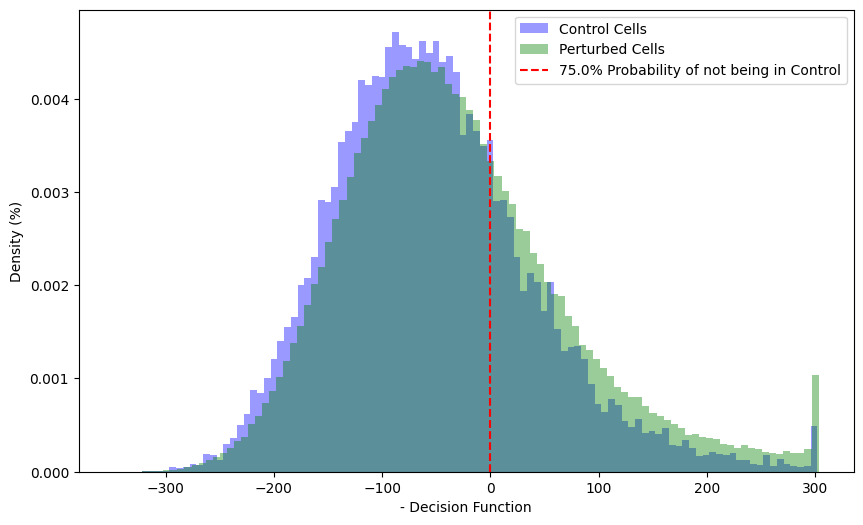

77533/245233 Perturbed Cells cross threshold of 0.75


In [12]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [13]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1388 ['NTC', 'SCAF4', 'CCDC6', 'CASP9', 'HCCS', 'LATS2', 'MZT2A', 'VPS33A', 'VHL', 'UBE2M', 'CDK5R1', 'PTPN1', 'CASP6', 'UBFD1', 'SLC30A1', 'PALD1', 'CASP3', 'C19orf12', 'PPP1R14B', 'ARHGDIA', 'STXBP2', 'CTAGE15', 'HRH3', 'BET1L', 'NAE1', 'PRR7', 'KCTD3', 'B3GALT6', 'MTRF1L', 'LAMTOR1', 'RNF41', 'RAB12', 'FASTKD5', 'FGFRL1', 'CYCS', 'BICD2', 'NDUFAF4', 'TEFM', 'CCDC71L', 'FZD9', 'IPO9', 'AMIGO2', 'C3orf80', 'MRPL36', 'IFFO1', 'RNF139', 'MIEF2', 'RAB5C', 'LRCH4', 'SPRY2', 'JOSD1', 'NKTR', 'TWSG1', 'KIF5A', 'PTEN', 'LAMTOR5', 'FTH1', 'CHEK2', 'AMOTL2', 'STARD3NL', 'RGS19', 'BCL2L13', 'SLC39A1', 'CD7', 'DEXI', 'POGLUT3', 'SNN', 'VPS39', 'CAPN1', 'USP38', 'INPP5J', 'C19orf47', 'TRAFD1', 'FGFR4', 'MST1R', 'PLCD3', 'UHMK1', 'MYLIP', 'B3GAT3', 'TUNAR', 'HLA-DOA', 'IL27RA', 'ADO', 'HNRNPM', 'TMEM167A', 'CD46', 'REEP6', 'GIPC1', 'RRM1', 'TOR1B', 'TBC1D13', 'CDH1', 'RNPEPL1', 'RPRD2', 'ENAH', 'TST', 'OLFML3', 'GRIK5', 'CDO1', 'ALAS1', 'FRAT2', 'ATP1A3', 'MRPL58', 'SV2A', 'NCKAP5L', 'SH2D2A', 'AG

In [14]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 873 perturbations for having under 25 cells.


In [15]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 75481 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [16]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed42.h5ad")

In [17]:
del adata_beta, adata_beta_filtered
gc.collect()

16595

GAMMA:

In [18]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


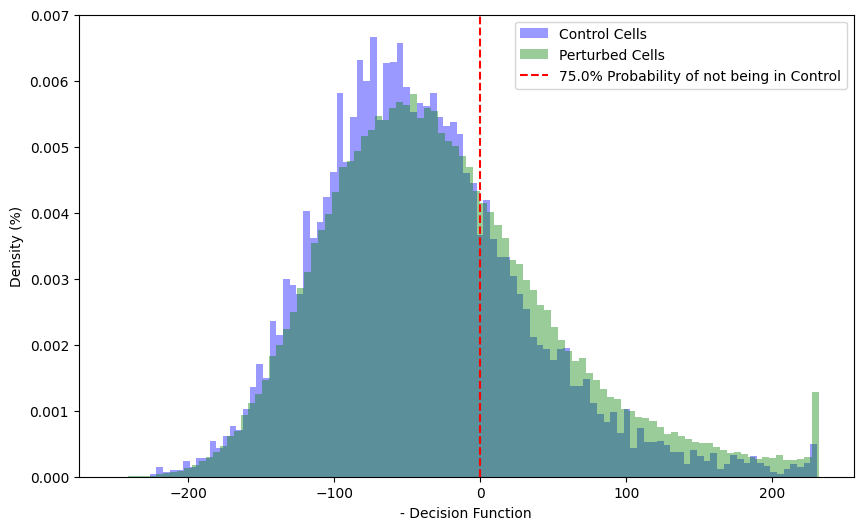

63300/202140 Perturbed Cells cross threshold of 0.75


In [19]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [20]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1064 ['NTC', 'SUPT20H', 'HS2ST1', 'FAM193A', 'NF2', 'CCDC18', 'PER2', 'RNF144A', 'MBP', 'FLYWCH2', 'RFK', 'ADAMTS13', 'SEL1L3', 'OGG1', 'FLCN', 'TIMM50', 'CAMK2N2', 'NOMO1', 'NNT', 'STOML1', 'MPC2', 'VAC14', 'CYP2R1', 'STXBP3', 'EIF4ENIF1', 'TGFBR2', 'CR2', 'FBXO31', 'CTAGE15', 'PIP4P2', 'FBXO42', 'SCAF8', 'FBXO17', 'ARHGEF10L', 'CDON', 'BAIAP3', 'STK38L', 'AP5S1', 'ANOS1', 'HCN2', 'CWF19L1', 'FAM83E', 'USP45', 'LRRC45', 'TMEM74B', 'AMER1', 'C3orf52', 'SREK1IP1', 'SPAG9', 'TSEN54', 'QTRT2', 'BICD1', 'MYO1B', 'AP5Z1', 'OSBPL7', 'BAD', 'SPHK1', 'CRIM1', 'PIGC', 'DNAJC16', 'IFT22', 'NAAA', 'SHISAL2B', 'TMEM120A', 'MON1A', 'C1orf21', 'RNF11', 'SLC37A1', 'RALGAPB', 'RGPD6', 'CXCL1', 'CNST', 'RSAD1', 'CCDC96', 'IGFBP5', 'NRBP1', 'MTPAP', 'MCU', 'MAPK6', 'MRPL4', 'PAN3', 'RTL8B', 'CDK5RAP1', 'SULT4A1', 'NRBP2', 'EMC7', 'PKIA', 'RAB33B', 'RBM5', 'CA2', 'NPIPA3', 'TAOK1', 'USP14', 'RETREG2', 'PTGR2', 'NPC1', 'TMEM63B', 'FAM221A', 'HAGH', 'SLC44A1', 'AGTPBP1', 'KCTD5', 'WHAMM', 'ETHE1', 'APAF1',

In [21]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1353 perturbations for having under 25 cells.


In [22]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 51783 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [23]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed42.h5ad")

Restart kernel

### Rerun SVM step with PCA random_state=42

Use PCA random_state = 42

In [2]:
step_f_rm_rand_seed = 42 # PCA random_state

ALPHA:

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [4]:
adata_alpha

AnnData object with n_obs × n_vars = 262550 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


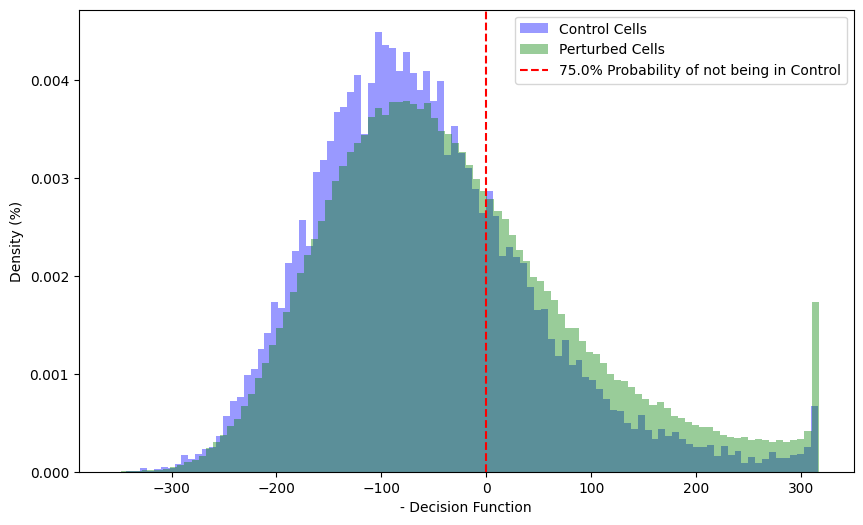

82408/249252 Perturbed Cells cross threshold of 0.75


In [5]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [6]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1480 ['NTC', 'HNF4A', 'KAT2A', 'VDR', 'LRPPRC', 'CABIN1', 'ZNF787', 'DNMT1', 'CHAMP1', 'PCGF1', 'EHMT1', 'TADA2B', 'POGZ', 'EMSY', 'ZNF273', 'NSD2', 'PNPT1', 'UHRF1', 'TBXT', 'INTS12', 'TAF6L', 'ZFP28', 'ZBTB22', 'FOXH1', 'ALKBH1', 'ZNF875', 'DDX6', 'ZNF396', 'EOMES', 'EHMT2', 'ZNF697', 'SIN3B', 'BMAL2', 'ELOC', 'TFAM', 'HIC1', 'ASS1', 'SOX4', 'ZNF426', 'ZNF419', 'ZNF829', 'ZFP57', 'ESRRA', 'NR0B1', 'SMARCC1', 'POU5F1', 'USP17L2', 'ACTB', 'PDP1', 'LEMD3', 'DOT1L', 'ZNF683', 'POLRMT', 'PRMT5', 'SNAI3', 'SMARCE1', 'ZNF287', 'ADNP2', 'OLIG1', 'BRD1', 'PKNOX2', 'BHLHE40', 'ZNF420', 'ZNF132', 'KMT2E', 'ZNF596', 'MTA2', 'ZNF556', 'HOXB3', 'NANOG', 'PARP16', 'SETDB1', 'CRTC2', 'SWAP70', 'H3-7', 'ZFP41', 'SLC22A1', 'ARHGAP35', 'ASF1A', 'FOXJ1', 'SUZ12', 'RCOR2', 'ZNF713', 'ZNF700', 'CDK13', 'RLIM', 'SSBP1', 'TCF21', 'MEIS3', 'RNASE6', 'SP4', 'ELL2', 'TDP1', 'ZNF557', 'CCNC', 'KMT2D', 'IRF9', 'SMAD4', 'POU2F3', 'ZNF735', 'ZNF17', 'H2BW2', 'ARNT2', 'GATAD1', 'EYA3', 'TACC1', 'KDM1A', 'PNLDC1', '

In [7]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [8]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 82528 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed4242.h5ad")

In [10]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16726

BETA:

In [11]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


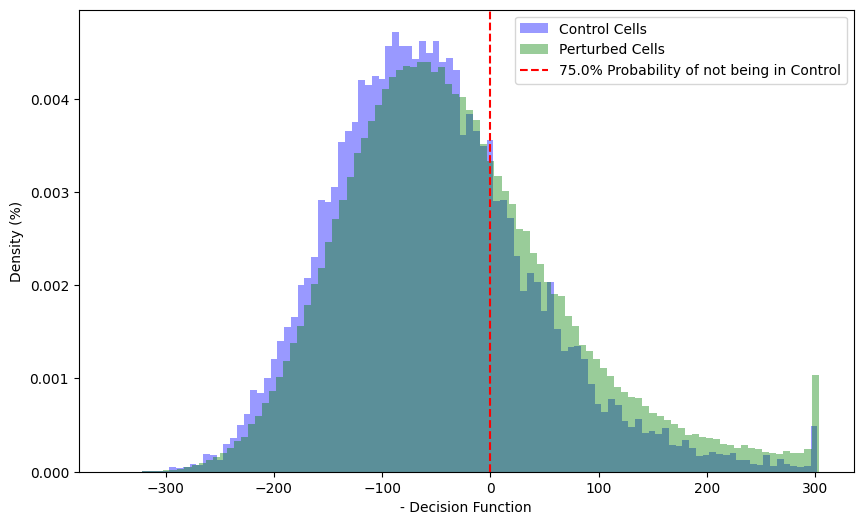

77535/245233 Perturbed Cells cross threshold of 0.75


In [12]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [13]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1388 ['NTC', 'SCAF4', 'CCDC6', 'CASP9', 'HCCS', 'LATS2', 'MZT2A', 'VPS33A', 'VHL', 'UBE2M', 'CASP6', 'CDK5R1', 'PTPN1', 'UBFD1', 'SLC30A1', 'PALD1', 'CASP3', 'C19orf12', 'PPP1R14B', 'ARHGDIA', 'STXBP2', 'CTAGE15', 'HRH3', 'BET1L', 'NAE1', 'PRR7', 'KCTD3', 'B3GALT6', 'LAMTOR1', 'MTRF1L', 'RAB12', 'RNF41', 'FASTKD5', 'FGFRL1', 'CYCS', 'BICD2', 'NDUFAF4', 'TEFM', 'CCDC71L', 'FZD9', 'IPO9', 'C3orf80', 'AMIGO2', 'IFFO1', 'MRPL36', 'MIEF2', 'RAB5C', 'RNF139', 'LRCH4', 'SPRY2', 'NKTR', 'JOSD1', 'KIF5A', 'TWSG1', 'CHEK2', 'FTH1', 'LAMTOR5', 'AMOTL2', 'STARD3NL', 'PTEN', 'RGS19', 'BCL2L13', 'CD7', 'SNN', 'CAPN1', 'POGLUT3', 'DEXI', 'SLC39A1', 'VPS39', 'USP38', 'INPP5J', 'C19orf47', 'MST1R', 'TRAFD1', 'FGFR4', 'PLCD3', 'MYLIP', 'UHMK1', 'B3GAT3', 'TUNAR', 'HLA-DOA', 'IL27RA', 'ADO', 'HNRNPM', 'REEP6', 'TMEM167A', 'CD46', 'GIPC1', 'RRM1', 'TOR1B', 'CDH1', 'RNPEPL1', 'TBC1D13', 'ENAH', 'OLFML3', 'TST', 'RPRD2', 'ALAS1', 'FRAT2', 'CDO1', 'GRIK5', 'TMX2', 'NCKAP5L', 'SV2A', 'TXNDC15', 'ATP1A3', 'MRP

In [14]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 873 perturbations for having under 25 cells.


In [15]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 75483 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [16]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed4242.h5ad")

In [17]:
del adata_beta, adata_beta_filtered
gc.collect()

16589

GAMMA:

In [18]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


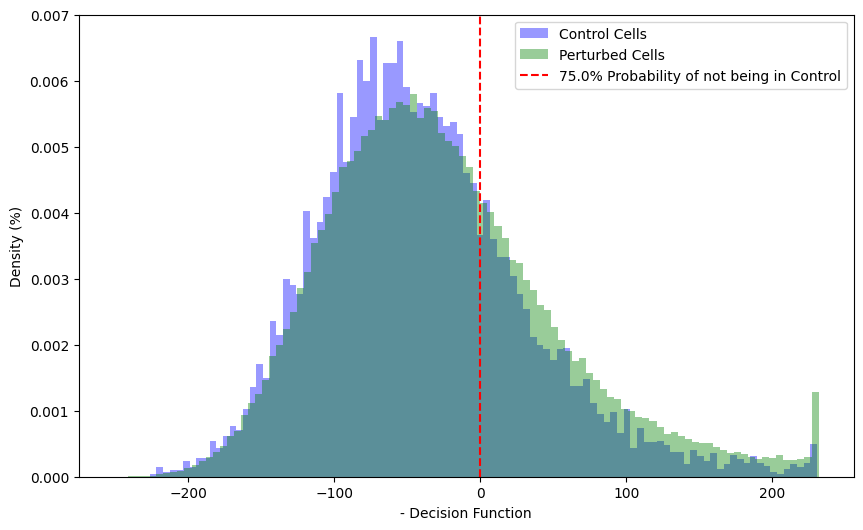

63300/202140 Perturbed Cells cross threshold of 0.75


In [19]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [20]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1064 ['NTC', 'SUPT20H', 'HS2ST1', 'FAM193A', 'NF2', 'CCDC18', 'PER2', 'RNF144A', 'MBP', 'FLYWCH2', 'RFK', 'ADAMTS13', 'SEL1L3', 'OGG1', 'FLCN', 'TIMM50', 'CAMK2N2', 'NOMO1', 'NNT', 'STOML1', 'MPC2', 'VAC14', 'CYP2R1', 'STXBP3', 'EIF4ENIF1', 'TGFBR2', 'CR2', 'FBXO31', 'CTAGE15', 'PIP4P2', 'FBXO42', 'SCAF8', 'FBXO17', 'ARHGEF10L', 'CDON', 'BAIAP3', 'STK38L', 'AP5S1', 'ANOS1', 'HCN2', 'CWF19L1', 'FAM83E', 'USP45', 'LRRC45', 'TMEM74B', 'AMER1', 'C3orf52', 'SREK1IP1', 'SPAG9', 'TSEN54', 'QTRT2', 'BICD1', 'MYO1B', 'AP5Z1', 'OSBPL7', 'BAD', 'SPHK1', 'CRIM1', 'PIGC', 'DNAJC16', 'IFT22', 'NAAA', 'SHISAL2B', 'TMEM120A', 'MON1A', 'C1orf21', 'RNF11', 'SLC37A1', 'RALGAPB', 'RGPD6', 'CXCL1', 'CNST', 'RSAD1', 'CCDC96', 'IGFBP5', 'NRBP1', 'MTPAP', 'MCU', 'MAPK6', 'MRPL4', 'PAN3', 'RTL8B', 'CDK5RAP1', 'SULT4A1', 'NRBP2', 'EMC7', 'PKIA', 'RAB33B', 'RBM5', 'CA2', 'NPIPA3', 'TAOK1', 'USP14', 'RETREG2', 'PTGR2', 'NPC1', 'TMEM63B', 'FAM221A', 'HAGH', 'SLC44A1', 'AGTPBP1', 'KCTD5', 'WHAMM', 'ETHE1', 'APAF1',

In [21]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1353 perturbations for having under 25 cells.


In [22]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 51783 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [23]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed4242.h5ad")

Restart kernel

Use seed 42 for E-distance testing and 0 for SVM

In [2]:
step_f_rm_rand_seed = 0 # PCA random_state

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


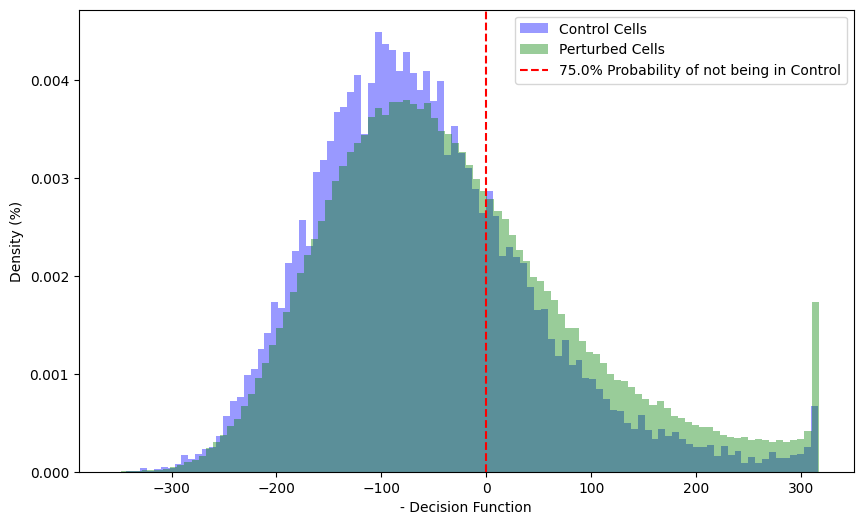

82407/249252 Perturbed Cells cross threshold of 0.75


In [4]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [5]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [6]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed420.h5ad")

In [7]:
del adata_alpha, adata_alpha_filtered
gc.collect()

18890

In [8]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed420.h5ad")

In [ ]:
del adata_beta, adata_beta_filtered
gc.collect()

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
adata_gama_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed420.h5ad")

Restart kernel

## Step F energy distance

In [5]:
stepF_alpha_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_beta_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_gamma_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad", backed="r")

In [7]:
energy_tf_kos_1337 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_1337, stepF_beta_energy_1337, stepF_gamma_energy_1337)

In [8]:
stepF_alpha_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad", backed="r")
stepF_beta_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad", backed="r")
stepF_gamma_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad", backed="r")

In [9]:
energy_tf_kos_42 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_42, stepF_beta_energy_42, stepF_gamma_energy_42)

In [ ]:
print("After Step F filtering based on energy distance testing:")
print(f"Seed 1337 = {len(energy_tf_kos_1337)} TF KOs, seed 42 = {len(energy_tf_kos_42)} TF KOs")
print(f"Shared = {len(energy_tf_kos_1337 & energy_tf_kos_42)} TF KOs")

After Step F filtering based on energy distance testing:
Seed 1337 = 905 TF KOs, seed 42 = 979 TF KOs
Shared = 682 TF KOs


## Step F SVM

In [5]:
stepF_alpha_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed42.h5ad", backed="r")
stepF_beta_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed42.h5ad", backed="r")
stepF_gamma_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed42.h5ad", backed="r")

In [7]:
svm_tf_kos_42_0 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_42_0, stepF_beta_svm_42_0, stepF_gamma_svm_42_0)

In [6]:
stepF_alpha_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed4242.h5ad", backed="r")
stepF_beta_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed4242.h5ad", backed="r")
stepF_gamma_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed4242.h5ad", backed="r")

In [8]:
svm_tf_kos_42_42 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_42_42, stepF_beta_svm_42_42, stepF_gamma_svm_42_42)

In [9]:
print("After Step F filtering based on SVM:")
print(f"SVM PCA seed 0 = {len(svm_tf_kos_42_0)} TF KOs, seed 42 = {len(svm_tf_kos_42_42)} TF KOs")
print(f"Shared = {len(svm_tf_kos_42_0 & svm_tf_kos_42_42)} TF KOs")

After Step F filtering based on SVM:
SVM PCA seed 0 = 674 TF KOs, seed 42 = 674 TF KOs
Shared = 674 TF KOs
